In [1]:
import numpy as np
import pandas as pd

In [2]:
data_directory = '/home/mytrah-pc/Mytrah_Adithya/data_turbine/ScatterData_Chakla_C66.csv'
file_name = ''
file_path = data_directory + file_name
turbine_state = 11

data_set = pd.read_csv(file_path)[['Timestamp', 'WindSpeed', 'ActivePower', 'TurbineState']]
data_set = data_set[data_set['ActivePower'] > 0]
data_set = data_set[data_set['TurbineState'] == turbine_state]
min_WindSpeed = data_set['WindSpeed'].min()
min_ActivePower = data_set['ActivePower'].min()
normalize_WindSpeed_factor = data_set['WindSpeed'].max() - min_WindSpeed
normalize_ActivePower_factor = data_set['ActivePower'].max() - min_ActivePower
data_set['scaled_WindSpeed'] = ((data_set['WindSpeed'] - min_WindSpeed) * 100 / normalize_WindSpeed_factor)
data_set['scaled_ActivePower'] = ((data_set['ActivePower'] - min_ActivePower) * 100 / normalize_ActivePower_factor)

def rounding_method(multiply_factor, round_off_by_factor):
    return lambda number: int(number * multiply_factor) + round_off_by_factor - int(number * multiply_factor) % round_off_by_factor

data_set['discrete_ActivePower'] = data_set['scaled_ActivePower'].apply(rounding_method(1, 2))
data_set.index = pd.to_datetime(data_set['Timestamp'])
del data_set['Timestamp']

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.scatter(data_set['scaled_WindSpeed'], data_set['discrete_ActivePower'])

In [4]:
from sklearn.cluster import KMeans, DBSCAN
n_kmeans_clusters = 14
kmeans_alg_obj = KMeans(n_clusters=n_kmeans_clusters)
dbscan_alg_obj = DBSCAN(eps=0.7, min_samples=1)
previous_width = -1
threshold_width_deviation = 1.8
allowed_width_deviation = threshold_width_deviation
epsilon_deviation = 0.33
change_width_for = {}
weight_min_width = 0.9
weight_max_width = 0.1
weight_max_deviation = 0.6
weight_min_deviation = 0.4
allowed_group_wind_speed_deviation = 0.13
min_points_in_group = 4
limit_elements_in_group_std = 1.6
limit_next_center_std = 0.5
right_most_dbkstd_limit = 1.4
left_most_dbkstd_limit = 1.4

for group in data_set.groupby('discrete_ActivePower'):
    if group[1].shape[0] <= n_kmeans_clusters:
        continue
    work_group = group[1].copy()
    kmeans_alg_obj.fit(work_group[['scaled_WindSpeed', 'discrete_ActivePower']])
    work_group['kmeans_label'] = kmeans_alg_obj.labels_
    work_group['dbscan_label'] = dbscan_alg_obj.fit_predict(work_group[['scaled_WindSpeed', 'discrete_ActivePower']])
    label_positions = [i[0] for i in sorted(enumerate(kmeans_alg_obj.cluster_centers_[:,0]), key=lambda x:x[1])]
    sorted_values = np.sort(kmeans_alg_obj.cluster_centers_[:,0], axis=0)
    current_width = sorted_values[-1] - sorted_values[0]
    if previous_width == -1:
        previous_width = current_width
        continue

    if np.std([previous_width, current_width]) < allowed_width_deviation:
        allowed_width_deviation = weight_min_deviation * np.min([(np.std([previous_width, current_width]) + epsilon_deviation), threshold_width_deviation]) \
                                + weight_max_deviation * np.max([(np.std([previous_width, current_width]) + epsilon_deviation), threshold_width_deviation])
        plt.scatter(group[1]['scaled_WindSpeed'].min(), group[0], c='#ff0000')
        plt.scatter(group[1]['scaled_WindSpeed'].max(), group[0], c='#ff0000')
        previous_width = weight_min_width * np.min([previous_width, current_width]) + weight_max_width * np.max([previous_width, current_width])

        if group[0] > 60 and group[0] < 65:
            print group[0], previous_width, current_width, np.std([previous_width, current_width])

        continue

    m = 0
    n = -1

    if group[0] > 60 and group[0] < 65:
        print sorted_values

    while (np.std([previous_width, current_width]) > allowed_width_deviation) and (current_width > previous_width):
        _group_kmeans_filter_m = work_group[work_group['kmeans_label'] == label_positions[m]]

        if ((n < -(n_kmeans_clusters - 2))
                or (((np.std(_group_kmeans_filter_m['scaled_WindSpeed']) < allowed_group_wind_speed_deviation)
                        or (_group_kmeans_filter_m.shape[0] < min_points_in_group))
                    and np.std([sorted_values[m], sorted_values[m + 1]]) > limit_next_center_std)):
            m = m + 1
            n = -1

        if ((np.std(_group_kmeans_filter_m['scaled_WindSpeed']) > limit_elements_in_group_std) 
                and (work_group[work_group['kmeans_label'] == label_positions[m]].shape[0] < min_points_in_group)):
            n = m
            break

        if m > (n_kmeans_clusters - 2):
            m = 0
            n = -1
            break

        n = n - 1
        current_width = sorted_values[n] - sorted_values[m]

    change_width_for[group[0]] = {}
    
    _max_dbscan_label = work_group.loc[work_group[work_group['kmeans_label'] == label_positions[n]]['scaled_WindSpeed'].idxmax()]['dbscan_label']
    _min_dbscan_label = work_group.loc[work_group[work_group['kmeans_label'] == label_positions[m]]['scaled_WindSpeed'].idxmin()]['dbscan_label']
    
    right_most_opt_dbscan = work_group[work_group['dbscan_label'] == _max_dbscan_label]['scaled_WindSpeed'].max()
    right_most_opt_kmeans = work_group[work_group['kmeans_label'] == label_positions[n]]['scaled_WindSpeed'].max()
    
    left_most_opt_dbscan = work_group[work_group['dbscan_label'] == _min_dbscan_label]['scaled_WindSpeed'].min()
    left_most_opt_kmeans = work_group[work_group['kmeans_label'] == label_positions[m]]['scaled_WindSpeed'].min()

    if np.std([right_most_opt_dbscan, right_most_opt_kmeans]) < right_most_dbkstd_limit:
        right_most = right_most_opt_dbscan
    else:
        right_most = right_most_opt_kmeans
        
    if np.std([left_most_opt_dbscan, left_most_opt_kmeans]) < left_most_dbkstd_limit:
        left_most = left_most_opt_dbscan
    else:
        left_most = left_most_opt_kmeans
    
    current_width = right_most - left_most

    change_width_for[group[0]]['l'] = left_most
    change_width_for[group[0]]['r'] = right_most
    previous_width = weight_min_width * np.min([previous_width, current_width]) + weight_max_width * np.max([previous_width, current_width])
    if group[0] > 60 and group[0] < 65:
        print group[0], m, n, previous_width, current_width, np.std([previous_width, current_width])

    m = 0
    n = -1
        
for x in change_width_for.keys():
    plt.scatter(change_width_for[x]['l'], x, c='#000000')
    plt.scatter(change_width_for[x]['r'], x, c='#000000')

[ 38.72878034  39.33727678  39.92531175  40.57562752  41.07593414
  41.62173971  42.33897098  42.96285283  43.54577636  44.85427349
  45.98878784  46.57925125  47.45563916  48.62758923]
62 0 -2 6.72391134615 10.2089018992 1.74249527651
[ 40.47897189  41.20503067  42.11760457  42.62267478  43.00695625
  43.32781634  43.72977184  44.11353849  44.92941744  46.85250847
  47.72575106  48.43898852  49.25179082  51.20512846]
64 0 -2 6.96757657697 9.16056365438 1.0964935387


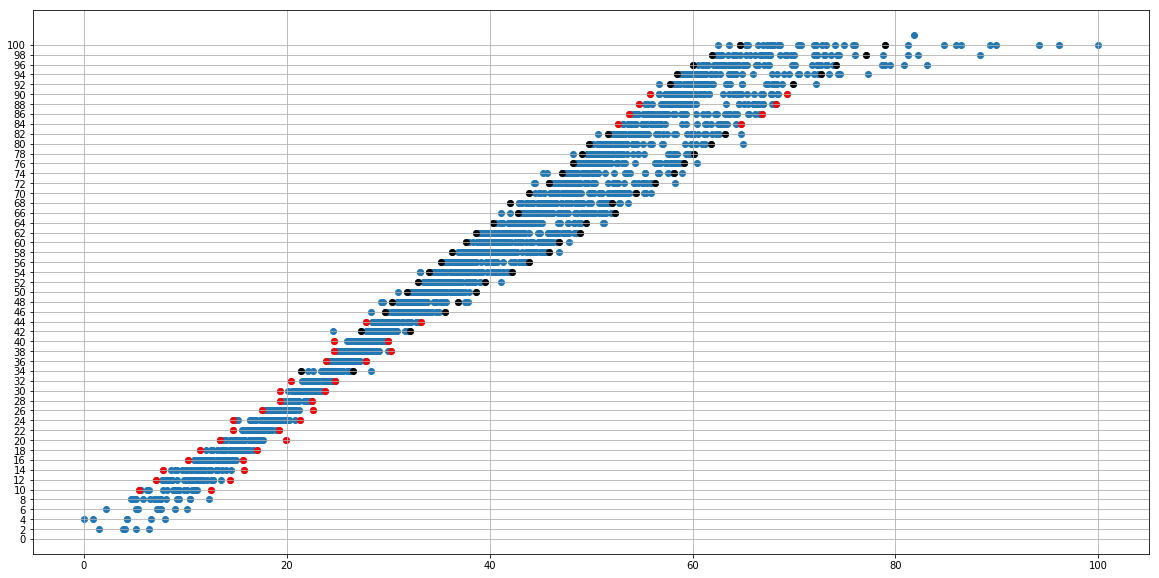

In [5]:
plt.yticks(np.arange(0, 102, 2))
plt.grid(True)
plt.show()